In [1]:
import torch
import random
import numpy as np

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 768),
            nn.ReLU(),
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 200),
            nn.ReLU(),
            nn.Linear(200, 128),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 200), 
            nn.ReLU(),
            nn.Linear(200, 256),
            nn.Tanh(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 768),
            nn.ReLU(),
            nn.Linear(768, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [100]:
from IPython import display

import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Download MNIST dataset
X_mnist, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# Normalize data
X_mnist = X_mnist / 255.0

In [101]:
X = X_mnist[y == '1'].to_numpy()
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

batch_size = X_tensor.shape[0]
train_loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size, shuffle=True)

In [102]:
input_dim = 784
latent_dim = 40

vae = VAE(input_dim, latent_dim)
vae.to(device)

history = {'loss': []}

In [103]:
import torch.optim as optim

optimizer = optim.Adam(vae.parameters(), lr=0.001)

def vae_loss(x_gen, x, mu, logvar):
    # Reconstruction loss
    gen_loss = F.binary_cross_entropy(x_gen, x.view(-1, input_dim), reduction='sum')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return gen_loss + kl_loss

In [104]:
import time
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_

num_epochs = 400000
verbose = False
pbar = tqdm(range(num_epochs))

# Saving best checkpoint
best_checkpoint = vae.state_dict()
min_loss = float('inf') 

# Spike prevention
max_grad_norm = 1.0

for epoch in pbar:
    vae.train()
    total_loss = 0
    t0 = time.time()
    for data in train_loader:
        optimizer.zero_grad()
        x = data[0]
        
        x_gen, mu, logvar = vae(x)
        loss = vae_loss(x_gen, x, mu, logvar)
        loss.backward()
        
        # Spike prevention
        clip_grad_norm_(vae.parameters(), max_grad_norm)
        
        optimizer.step()
        
        total_loss += loss.item()
    t1 = time.time()
    if epoch % 50 == 0:
        pbar.set_description('Loss: {:.4f} | {:.2f}s'.format(
            total_loss / len(train_loader), 
            t1-t0
        ))
    history['loss'].append(total_loss / len(train_loader))
    
    # Saving best checkpoint
    if loss.item() / len(train_loader) < min_loss:
        min_loss = loss.item() / len(train_loader)
        best_checkpoint = vae.state_dict()
    
    if verbose and epoch % 5 == 0:
        random_point = torch.rand((latent_dim,))
        x_gen = vae.decode(random_point.reshape(1, -1))
        plt.imshow(x_gen.detach().numpy().reshape(28,28), cmap='gray')
        plt.show()

Loss: 357139.5625 | 0.05s: 100%|██████| 400000/400000 [6:50:28<00:00, 16.24it/s]


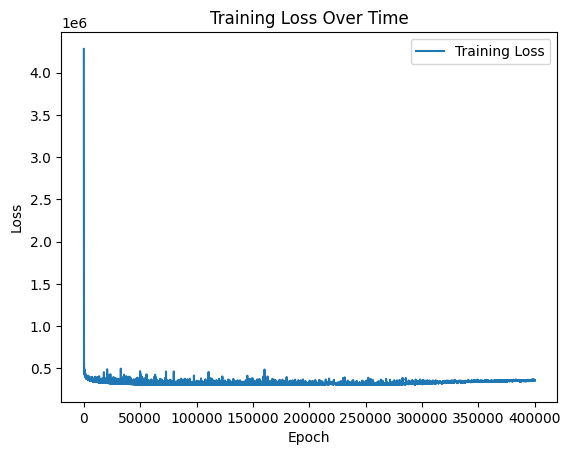

In [105]:
import matplotlib.pyplot as plt

plt.plot(history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

In [106]:
a = -3
b = 3
data_uniform = (b-a)*torch.rand((X.shape[0], latent_dim)).to(device) + a
data_uniform.shape

torch.Size([7877, 40])

In [107]:
generated_images = []
with torch.no_grad():
    for i, random_point in enumerate(data_uniform):
        generated_images.append(vae.decode(random_point.reshape(1, -1)).reshape(-1))

In [108]:
X_gen = np.array([x.detach().cpu().numpy() for x in generated_images])
assert X_gen.shape == X.shape

In [109]:
X_knn = np.vstack([X, X_gen])
y_knn = np.array(X.shape[0]*[1] + X_gen.shape[0]*[0])

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size=0.3, random_state=42)

# Create kNN classifier. You can adjust the number of neighbors (n_neighbors)
knn = KNeighborsClassifier(n_neighbors=3)

# Train the classifier
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 65.56%


In [111]:
def plot_generated_images(generated_images):
    plt.figure(figsize=(10, 10))
    for i in range(10):
        for j in range(10):           
            plt.subplot(10, 10, i*10+j+1)
            plt.imshow(generated_images[i*10 + j].cpu().numpy().reshape(28,28), cmap='gray')
            plt.axis('off')
    plt.show()

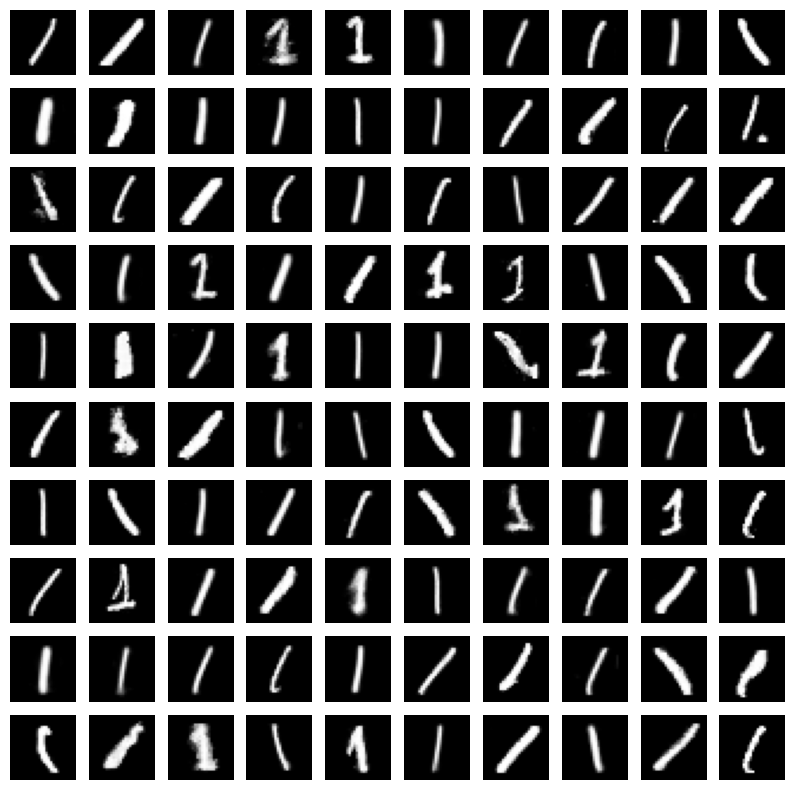

In [112]:
plot_generated_images(generated_images)

# Best model

In [113]:
last_checkpoint = vae.state_dict()
vae.load_state_dict(best_checkpoint)

<All keys matched successfully>

In [114]:
generated_images = []
with torch.no_grad():
    for i, random_point in enumerate(data_uniform):
        generated_images.append(vae.decode(random_point.reshape(1, -1)).reshape(-1))

In [115]:
X_gen = np.array([x.detach().cpu().numpy() for x in generated_images])
assert X_gen.shape == X.shape

In [116]:
X_knn = np.vstack([X, X_gen])
y_knn = np.array(X.shape[0]*[1] + X_gen.shape[0]*[0])

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size=0.3, random_state=42)

# Create kNN classifier. You can adjust the number of neighbors (n_neighbors)
knn = KNeighborsClassifier(n_neighbors=3)

# Train the classifier
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 65.56%


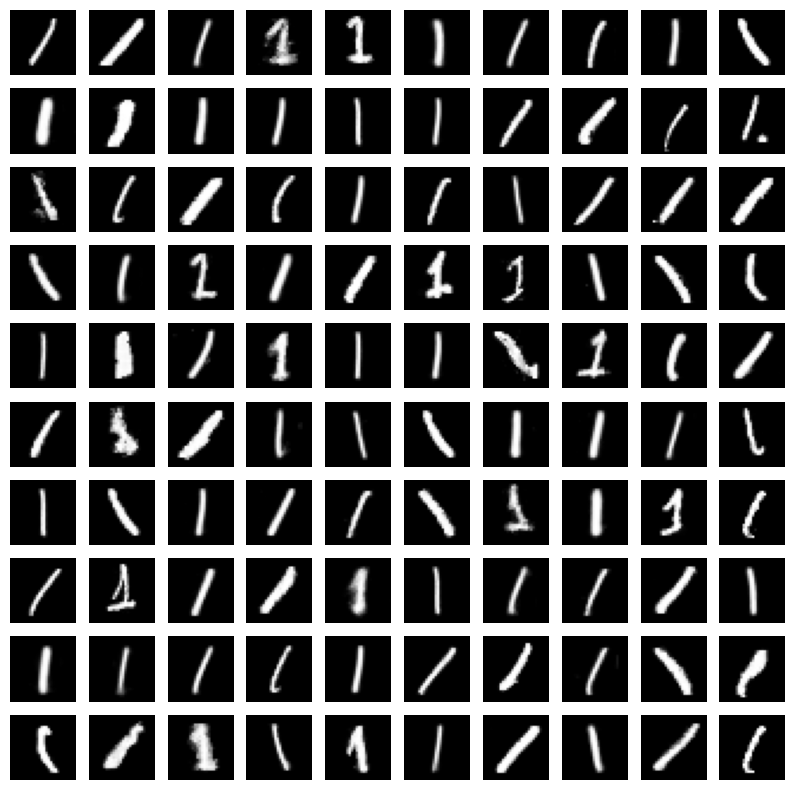

In [118]:
plot_generated_images(generated_images)